<a href="https://colab.research.google.com/github/Inteli-College/2024-2A-T05-CC09-G04/blob/classificacao-spriint3/resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1. Carregamento e Preparo do Dataset


In [ ]:
!pip install keras
!pip install tensorflow


In [ ]:
import pickle
import h5py
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Função para carregar arquivos pkl
def load_pkl(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

# Função para carregar arquivo h5
def load_h5(file_path):
    with h5py.File(file_path, 'r') as f:
        data = np.array(f['X'])
    return data

# Função para extrair as imagens (em caso de pkl ter outras informações)
def extract_images(data):
    # Se as imagens estão em tuplas, vamos pegar a segunda parte da tupla
    if isinstance(data[0], tuple):
        images = [item[1] for item in data]  # Acessando a segunda parte da tupla
    else:
        images = data
    return images

# Função para duplicar canal e redimensionar
def preprocess_images(images, target_size=(224, 224)):
    processed_images = []
    for img in images:
        # Se a imagem for grayscale, duplicamos o canal para RGB
        if len(img.shape) == 2:  # Grayscale
            img_rgb = np.stack([img]*3, axis=-1)
        else:
            img_rgb = img

        # Redimensionar a imagem
        img_resized = cv2.resize(img_rgb, target_size)
        processed_images.append(img_resized)

    return np.array(processed_images)

# Função para remover duplicatas com base nos valores de pixel
def remove_duplicates(images, labels):
    unique_images = []
    unique_labels = []
    seen_images = set()

    for i, img in enumerate(images):
        img_str = str(img.flatten())  # Flatten a imagem e converte em string para identificar duplicatas
        if img_str not in seen_images:
            seen_images.add(img_str)
            unique_images.append(img)
            unique_labels.append(labels[i])

    return np.array(unique_images), np.array(unique_labels)

# Carregar os arquivos de dados
path_train_com_cabeca = "/content/drive/MyDrive/dataset/com_cabeca/train.pkl"
path_test_com_cabeca = "/content/drive/MyDrive/dataset/com_cabeca/test.pkl"
path_sem_cabeca = "/content/drive/MyDrive/dataset/sem_cabeca/negative_X (1).h5"

# Carregar e extrair as imagens "com cabeça"
train_com_cabeca = load_pkl(path_train_com_cabeca)
test_com_cabeca = load_pkl(path_test_com_cabeca)

# Extrair as imagens (pegando o segundo item da tupla)
train_com_cabeca_images = extract_images(train_com_cabeca)
test_com_cabeca_images = extract_images(test_com_cabeca)

# Carregar e pré-processar as imagens "sem cabeça"
sem_cabeca_images = load_h5(path_sem_cabeca)
sem_cabeca_preprocessed = preprocess_images(sem_cabeca_images)

# Separar "sem cabeça" entre treino e teste
sem_cabeca_train, sem_cabeca_test = train_test_split(sem_cabeca_preprocessed, test_size=0.2, random_state=42)

# Pré-processar as imagens "com cabeça"
train_com_cabeca_preprocessed = preprocess_images(train_com_cabeca_images)
test_com_cabeca_preprocessed = preprocess_images(test_com_cabeca_images)

# Criar rótulos para "com cabeça" (1) e "sem cabeça" (0)
labels_com_cabeca_train = np.ones(len(train_com_cabeca_preprocessed))
labels_com_cabeca_test = np.ones(len(test_com_cabeca_preprocessed))
labels_sem_cabeca_train = np.zeros(len(sem_cabeca_train))
labels_sem_cabeca_test = np.zeros(len(sem_cabeca_test))

# Concatenar os dados de treino (com cabeça e sem cabeça)
X_train = np.concatenate([train_com_cabeca_preprocessed, sem_cabeca_train], axis=0)
y_train = np.concatenate([labels_com_cabeca_train, labels_sem_cabeca_train], axis=0)

# Concatenar os dados de teste (com cabeça e sem cabeça)
X_test = np.concatenate([test_com_cabeca_preprocessed, sem_cabeca_test], axis=0)
y_test = np.concatenate([labels_com_cabeca_test, labels_sem_cabeca_test], axis=0)

# Dividir o conjunto de treino em treino e validação
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Normalizar as imagens (ResNet espera valores entre 0 e 1)
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Verificar as formas dos dados processados
print("Tamanho do conjunto de treino:", X_train.shape)
print("Tamanho do conjunto de validação:", X_val.shape)
print("Tamanho do conjunto de teste:", X_test.shape)

# Função para verificar sobreposição
def check_overlap(X_train, X_val, X_test):
    train_set = {str(img.flatten()) for img in X_train}
    val_set = {str(img.flatten()) for img in X_val}
    test_set = {str(img.flatten()) for img in X_test}

    overlap_train_val = train_set.intersection(val_set)
    overlap_train_test = train_set.intersection(test_set)
    overlap_val_test = val_set.intersection(test_set)

    print(f"Sobreposição entre treino e validação: {len(overlap_train_val)}")
    print(f"Sobreposição entre treino e teste: {len(overlap_train_test)}")
    print(f"Sobreposição entre validação e teste: {len(overlap_val_test)}")

# Verificar a sobreposição:
check_overlap(X_train, X_val, X_test)


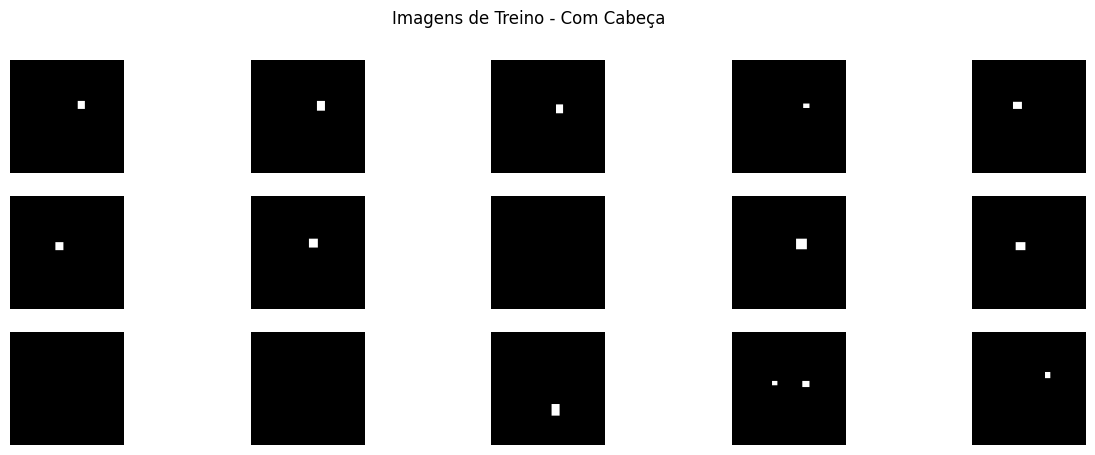

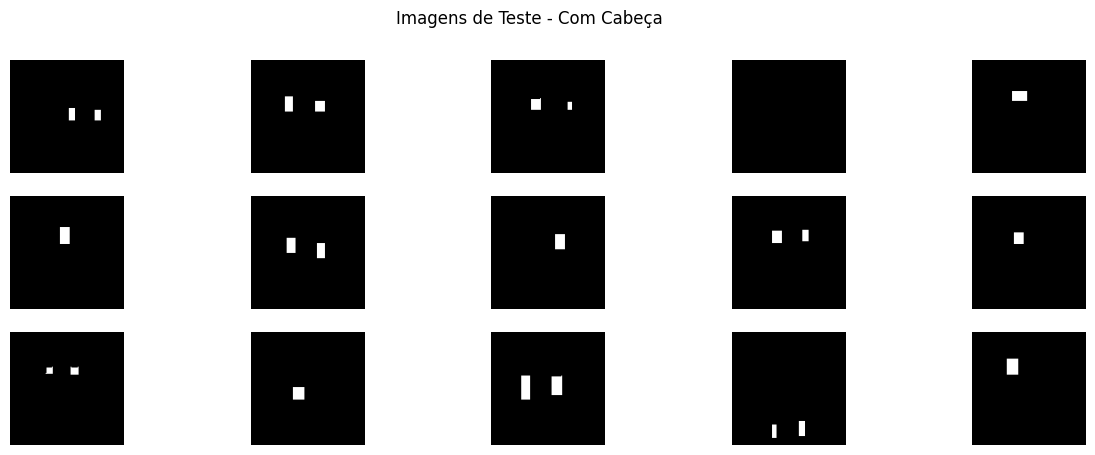

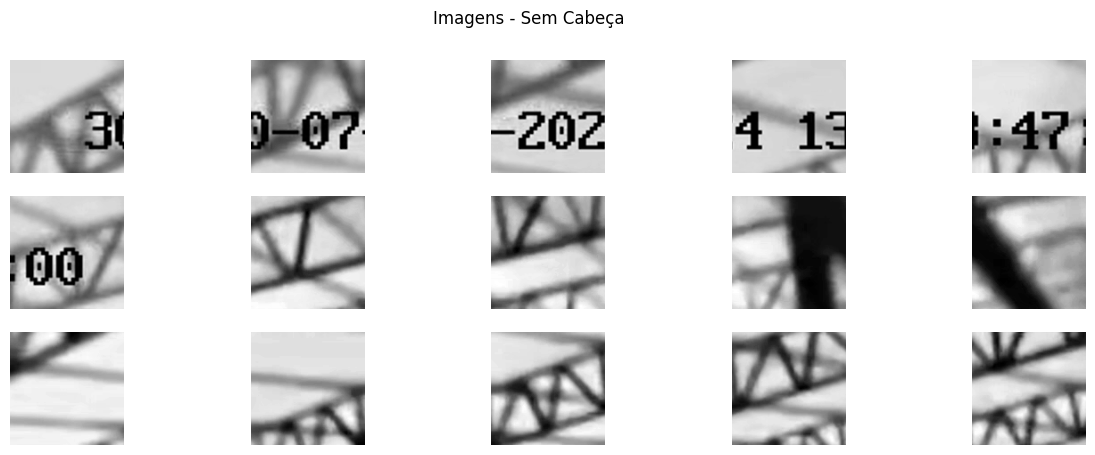

In [ ]:
import matplotlib.pyplot as plt

# Função para plotar as imagens
def plot_images(images, title, num_images=15):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(3, 5, i + 1)
        plt.imshow(images[i], cmap='gray')  # Use cmap='gray' se forem imagens em grayscale
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Plotar 15 imagens de cada conjunto
plot_images(train_com_cabeca_images, "Imagens de Treino - Com Cabeça", num_images=15)
plot_images(test_com_cabeca_images, "Imagens de Teste - Com Cabeça", num_images=15)
plot_images(sem_cabeca_images, "Imagens - Sem Cabeça", num_images=15)


In [ ]:
# Verificar o balanceamento de classes no treino, validação e teste
def check_class_balance(y_train, y_val, y_test):
    print("Distribuição de classes no treino:")
    print(np.bincount(y_train.astype(int)))

    print("Distribuição de classes na validação:")
    print(np.bincount(y_val.astype(int)))

    print("Distribuição de classes no teste:")
    print(np.bincount(y_test.astype(int)))

# Chamar a função de verificação de balanceamento de classes
check_class_balance(y_train, y_val, y_test)


Distribuição de classes no treino:
[1542 2461]
Distribuição de classes na validação:
[378 623]
Distribuição de classes no teste:
[480 774]


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2



# Carregar o modelo ResNet50 pré-treinado no ImageNet, sem incluir as camadas fully connected do topo (top=False)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar as camadas da base da ResNet para não treinar novamente
for layer in base_model.layers:
    layer.trainable = False

# Adicionar novas camadas no topo para a nossa classificação binária
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling global
x = Dense(256, activation='relu')(x)  # 0.001 is the regularization factor ; add , kernel_regularizer=l2(0.001)
x = Dropout(0.2)(x)  # Dropout de 30%
predictions = Dense(1, activation='sigmoid')(x)  # Camada de saída binária

# Criar o modelo final
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar o modelo
model.compile(optimizer=Adam(learning_rate=1e-4),  # Taxa de aprendizado baixa
              loss='binary_crossentropy',          # Perda para classificação binária
              metrics=['accuracy'])

# Resumo do modelo
#model.summary()


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation para o conjunto de treino
train_datagen = ImageDataGenerator(
    rotation_range=20,       # Rotaciona a imagem até 20 graus
    width_shift_range=0.2,   # Translação horizontal
    height_shift_range=0.2,  # Translação vertical
    shear_range=0.2,         # Distorção
    zoom_range=0.2,          # Zoom
    horizontal_flip=True,    # Flip horizontal
    fill_mode='nearest'      # Preenchimento de pixels ausentes
)

# Sem Data Augmentation para validação
val_datagen = ImageDataGenerator()

# Criar geradores para os dados
train_generator = train_datagen.flow(X_train, y_train, batch_size=16)
val_generator = val_datagen.flow(X_val, y_val, batch_size=16)


In [ ]:
# Exemplo de como definir class_weight para um conjunto desbalanceado
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

print(class_weights)

[1.29798962 0.81328728]


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stopping para parar o treino se a validação não melhorar
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Checkpoint para salvar o melhor modelo baseado na validação
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')

# Ajustar o modelo para treinamento
history = model.fit(train_generator,
                    epochs=30,
                    validation_data=val_generator,
                    class_weight=class_weight_dict,
                    callbacks=[early_stopping, checkpoint])


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


251/251 ━━━━━━━━━━━━━━━━━━━━ 58s 190ms/step - accuracy: 0.6063 - loss: 0.6589 - val_accuracy: 0.9391 - val_loss: 0.5049
Epoch 2/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 40s 157ms/step - accuracy: 0.8292 - loss: 0.5049 - val_accuracy: 0.9550 - val_loss: 0.3722
Epoch 3/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 158ms/step - accuracy: 0.8806 - loss: 0.4056 - val_accuracy: 0.9530 - val_loss: 0.2966
Epoch 4/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 159ms/step - accuracy: 0.8980 - loss: 0.3381 - val_accuracy: 0.9530 - val_loss: 0.2453
Epoch 5/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 158ms/step - accuracy: 0.9047 - loss: 0.2974 - val_accuracy: 0.9530 - val_loss: 0.2145
Epoch 6/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 158ms/step - accuracy: 0.9002 - loss: 0.2719 - val_accuracy: 0.9441 - val_loss: 0.2099
Epoch 7/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 158ms/step - accuracy: 0.9151 - loss: 0.2422 - val_accuracy: 0.9560 - val_loss: 0.1764
Epoch 8/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 158ms/step - accuracy: 0.9230 - loss: 0.2173 - val

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

# Função para plotar a acurácia e perda do treino e validação
def plot_history(history):
    # Plotar acurácia
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Acurácia Treino')
    plt.plot(history.history['val_accuracy'], label='Acurácia Validação')
    plt.title('Acurácia Treino vs Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()

    # Plotar perda
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Perda Treino')
    plt.plot(history.history['val_loss'], label='Perda Validação')
    plt.title('Perda Treino vs Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    plt.show()

# Plotar os resultados
plot_history(history)


In [ ]:
import pickle
import h5py
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Função para carregar arquivos pkl
def load_pkl(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

# Função para carregar arquivo h5
def load_h5(file_path):
    with h5py.File(file_path, 'r') as f:
        data = np.array(f['X'])
    return data

# Função para extrair as imagens (em caso de pkl ter outras informações)
def extract_images(data):
    # Se as imagens estão em tuplas, vamos pegar a segunda parte da tupla
    if isinstance(data[0], tuple):
        images = [item[1] for item in data]  # Acessando a segunda parte da tupla
    else:
        images = data
    return images

# Função para duplicar canal e redimensionar
def preprocess_images(images, target_size=(224, 224)):
    processed_images = []
    for img in images:
        # Se a imagem for grayscale, duplicamos o canal para RGB
        if len(img.shape) == 2:  # Grayscale
            img_rgb = np.stack([img]*3, axis=-1)
        else:
            img_rgb = img

        # Redimensionar a imagem
        img_resized = cv2.resize(img_rgb, target_size)
        processed_images.append(img_resized)

    return np.array(processed_images)

# Carregar os arquivos de dados
path_train_com_cabeca = "/content/drive/MyDrive/dataset/com_cabeca/train.pkl"
path_test_com_cabeca = "/content/drive/MyDrive/dataset/com_cabeca/test.pkl"
path_sem_cabeca = "/content/drive/MyDrive/dataset/sem_cabeca/negative_X (1).h5"

# Carregar e extrair as imagens
train_com_cabeca = load_pkl(path_train_com_cabeca)
test_com_cabeca = load_pkl(path_test_com_cabeca)
sem_cabeca = load_h5(path_sem_cabeca)

# Extrair as imagens (pegando o segundo item da tupla)
train_com_cabeca_images = extract_images(train_com_cabeca)
test_com_cabeca_images = extract_images(test_com_cabeca)

# Pré-processar as imagens (duplicar canal e redimensionar)
train_com_cabeca_preprocessed = preprocess_images(train_com_cabeca_images)
test_com_cabeca_preprocessed = preprocess_images(test_com_cabeca_images)
sem_cabeca_preprocessed = preprocess_images(sem_cabeca)

# Concatenar todas as imagens "com cabeça" e "sem cabeça"
all_images = np.concatenate([train_com_cabeca_preprocessed, test_com_cabeca_preprocessed, sem_cabeca_preprocessed], axis=0)

# Criar os rótulos correspondentes
labels_com_cabeca = np.ones(len(train_com_cabeca_preprocessed) + len(test_com_cabeca_preprocessed))
labels_sem_cabeca = np.zeros(len(sem_cabeca_preprocessed))
all_labels = np.concatenate([labels_com_cabeca, labels_sem_cabeca], axis=0)

# Criação de IDs únicos para cada imagem
image_ids = np.arange(len(all_images))

# Dividir os IDs das imagens sem sobreposição
train_ids, temp_ids, y_train, y_temp = train_test_split(image_ids, all_labels, test_size=0.4, random_state=42)
val_ids, test_ids, y_val, y_test = train_test_split(temp_ids, y_temp, test_size=0.5, random_state=42)

# Agora selecionamos as imagens com base nos IDs divididos
X_train = all_images[train_ids]
X_val = all_images[val_ids]
X_test = all_images[test_ids]

# Normalizar as imagens (ResNet espera valores entre 0 e 1)
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Verificar as formas dos dados processados
print("Tamanho do conjunto de treino:", X_train.shape)
print("Tamanho do conjunto de validação:", X_val.shape)
print("Tamanho do conjunto de teste:", X_test.shape)

# Função para verificar sobreposição
def check_overlap(X_train, X_val, X_test):
    train_set = {str(img.flatten()) for img in X_train}
    val_set = {str(img.flatten()) for img in X_val}
    test_set = {str(img.flatten()) for img in X_test}

    overlap_train_val = train_set.intersection(val_set)
    overlap_train_test = train_set.intersection(test_set)
    overlap_val_test = val_set.intersection(test_set)

    print(f"Sobreposição entre treino e validação: {len(overlap_train_val)}")
    print(f"Sobreposição entre treino e teste: {len(overlap_train_test)}")
    print(f"Sobreposição entre validação e teste: {len(overlap_val_test)}")

# Verificar a sobreposição:
check_overlap(X_train, X_val, X_test)


In [ ]:
import pickle

# Function to load pickle file and return its contents
def load_pickle_file(path):
    with open(path, 'rb') as file:
        return pickle.load(file)


# Load the data
train_data_com_cabeca = load_pickle_file(path_train_com_cabeca)

# Check the structure and types of the elements in the loaded data
print(type(train_data_com_cabeca))
print(len(train_data_com_cabeca))
print(train_data_com_cabeca[0])  # Inspect the first element
